In [1]:
# !pip uninstall virny -y

In [2]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@development

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@development

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from virny.datasets import ACSEmploymentDataset
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart
from virny.utils.custom_initializers import create_models_config_from_tuned_params_df

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [5]:
DATASET_SPLIT_SEED = 42
MODELS_TUNING_SEED = 42
TEST_SET_FRACTION = 0.2
DATASET_NAME = 'ACS_Employment_CA_2018'

sensitive_attributes_dct = {'SEX': '2', 'RAC1P': ['2', '3', '4', '5', '6', '7', '8', '9'], 'SEX & RAC1P': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [6]:
data_loader = ACSEmploymentDataset(state=['CA'], year=2018, with_nulls=False)
data_loader.full_df.head()

,MAR,MIL,ESP,MIG,DREM,NATIVITY,DIS,DEAR,DEYE,SEX,RAC1P,RELP,CIT,ANC,SCHL,AGEP,ESR
0,1,4,0,3,2,1,2,2,2,1,8,16,1,1,14,30,0
1,5,4,0,1,2,1,2,2,2,2,1,17,1,1,14,18,0
2,1,2,0,1,2,1,1,2,2,1,9,17,1,2,17,69,0
3,5,4,0,1,1,1,1,1,2,1,1,17,1,1,1,25,0
4,5,4,0,1,2,1,2,2,2,2,1,16,1,1,18,31,0


In [7]:
data_loader.target

'ESR'

In [8]:
data_loader.full_df.shape

(302640, 17)

In [9]:
data_loader.full_df.isnull().sum()

MAR         0
MIL         0
ESP         0
MIG         0
DREM        0
NATIVITY    0
DIS         0
DEAR        0
DEYE        0
SEX         0
RAC1P       0
RELP        0
CIT         0
ANC         0
SCHL        0
AGEP        0
ESR         0
dtype: int64

In [10]:
data_loader.full_df['SCHL'].unique()

array(['14', '17', '1', '18', '16', '22', '19', '15', '21', '10', '11',
       '13', '12', '3', '9', '5', '20', '23', '8', '6', '7', '24', '4',
       '2'], dtype=object)

## Check proportions and base rates

In [12]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

In [12]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, {'DIS': '1', 'DREM': '1', 'MIL': ['2', '3']})

alt.FacetChart(...)

In [19]:
data_loader.X_data['DIS_all'] = data_loader.X_data.apply(
    lambda row: '1' if row['DEAR'] == '1' or row['DEYE'] == '1' or row['DREM'] == '1' or row['DIS'] == '1' else '2', axis=1
)

In [20]:
# Compare the two columns
(data_loader.X_data['DIS_all'] != data_loader.X_data['DIS']).sum()

0

In [18]:
data_loader.X_data['DIS'][data_loader.X_data['DIS_all'] != data_loader.X_data['DIS']].unique()

array(['1'], dtype=object)

In [15]:
data_loader.X_data['DIS_all'][data_loader.X_data['DIS_all'] != data_loader.X_data['DIS']].unique()

array(['2'], dtype=object)

In [22]:
data_loader.X_data['SCHL'].unique()

array(['14', '17', '1', '18', '16', '22', '19', '15', '21', '10', '11',
       '13', '12', '3', '9', '5', '20', '23', '8', '6', '7', '24', '4',
       '2'], dtype=object)

### Data Profiling

In [31]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

MAR: 5
MIL: 4
ESP: 9
MIG: 3
DREM: 2
NATIVITY: 2
DIS: 2
DEAR: 2
DEYE: 2
SEX: 2
RAC1P: 9
RELP: 18
CIT: 5
ANC: 4
SCHL: 24


In [32]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [33]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['MAR_1',
 'MAR_2',
 'MAR_3',
 'MAR_4',
 'MAR_5',
 'MIL_1',
 'MIL_2',
 'MIL_3',
 'MIL_4',
 'ESP_0',
 'ESP_1',
 'ESP_2',
 'ESP_3',
 'ESP_4',
 'ESP_5',
 'ESP_6',
 'ESP_7',
 'ESP_8',
 'MIG_1',
 'MIG_2',
 'MIG_3',
 'DREM_1',
 'DREM_2',
 'NATIVITY_1',
 'NATIVITY_2',
 'DIS_1',
 'DIS_2',
 'DEAR_1',
 'DEAR_2',
 'DEYE_1',
 'DEYE_2',
 'SEX_1',
 'SEX_2',
 'RAC1P_1',
 'RAC1P_2',
 'RAC1P_3',
 'RAC1P_4',
 'RAC1P_5',
 'RAC1P_6',
 'RAC1P_7',
 'RAC1P_8',
 'RAC1P_9',
 'RELP_0',
 'RELP_1',
 'RELP_10',
 'RELP_11',
 'RELP_12',
 'RELP_13',
 'RELP_14',
 'RELP_15',
 'RELP_16',
 'RELP_17',
 'RELP_2',
 'RELP_3',
 'RELP_4',
 'RELP_5',
 'RELP_6',
 'RELP_7',
 'RELP_8',
 'RELP_9',
 'CIT_1',
 'CIT_2',
 'CIT_3',
 'CIT_4',
 'CIT_5',
 'ANC_1',
 'ANC_2',
 'ANC_3',
 'ANC_4',
 'SCHL_1',
 'SCHL_10',
 'SCHL_11',
 'SCHL_12',
 'SCHL_13',
 'SCHL_14',
 'SCHL_15',
 'SCHL_16',
 'SCHL_17',
 'SCHL_18',
 'SCHL_19',
 'SCHL_2',
 'SCHL_20',
 'SCHL_21',
 'SCHL_22',
 'SCHL_23',
 'SCHL_24',
 'SCHL_3',
 'SCHL_4',
 'SCHL_5',
 'SCHL_6',
 'SC

### Correlation of sensitive attributes with the target

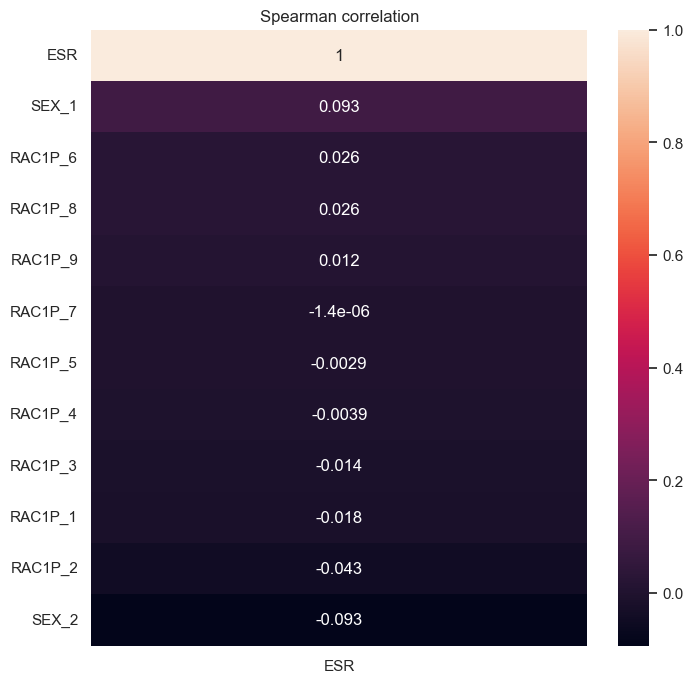

In [34]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(8, 8))

### Correlation of selected attributes with the target

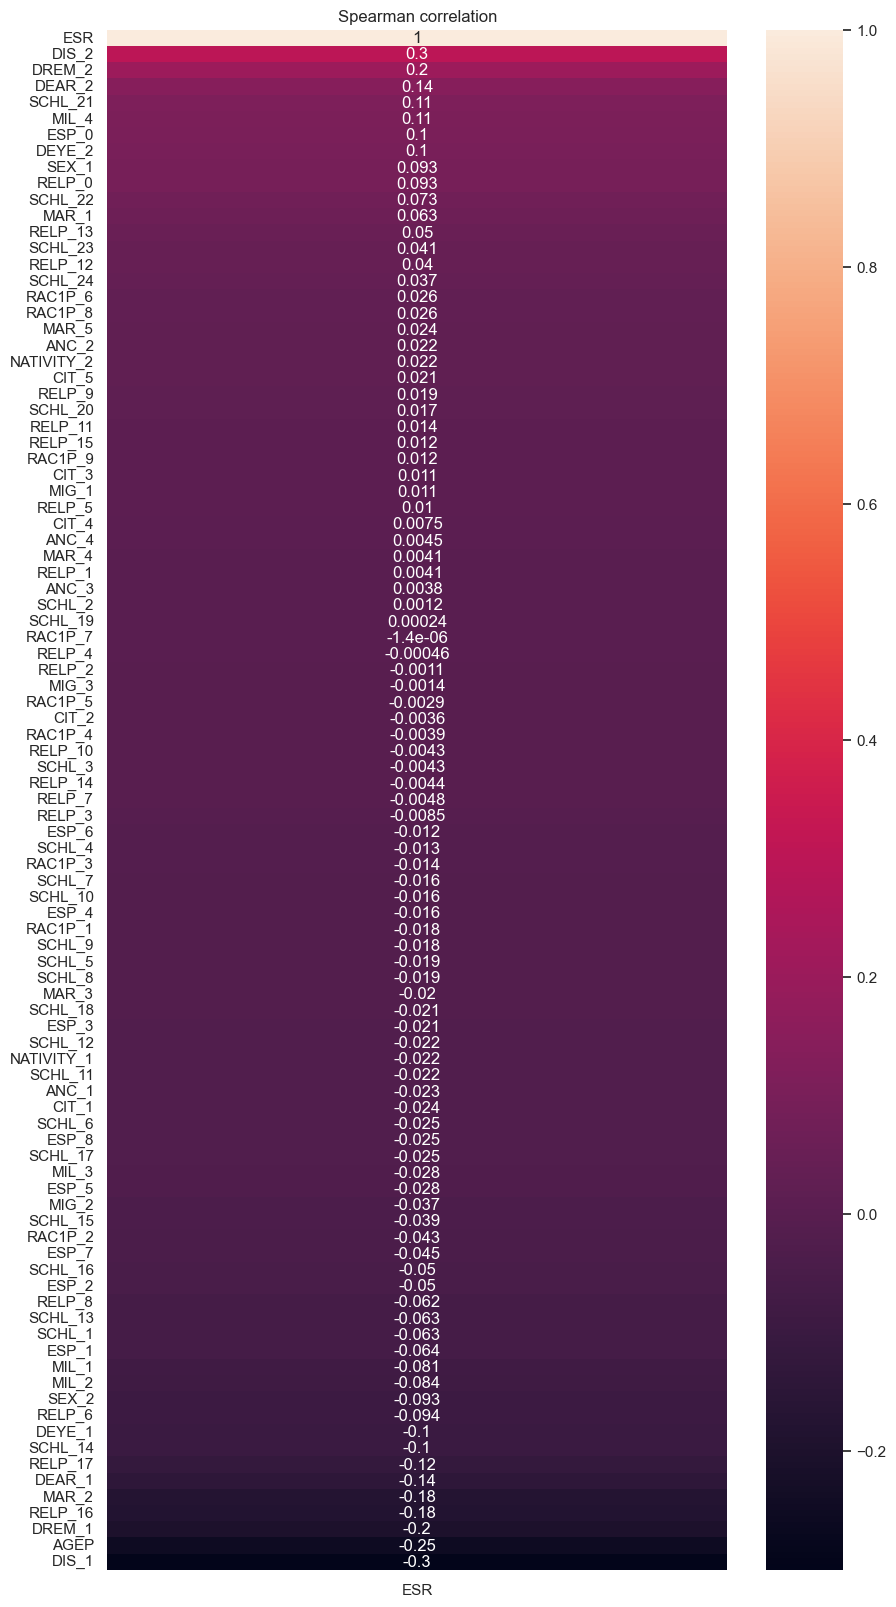

In [35]:
filtered_feature_names = [col for col in full_processed_df.columns \
                          if col != data_loader.target \
                           and not col.startswith('OCCP') \
                           and not col.startswith('POBP')]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(20, 10))

### Correlation matrix for features which have high correlation with the target

In [36]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.1
)
high_correlated_features

['MAR_2',
 'MIL_4',
 'ESP_0',
 'DREM_1',
 'DREM_2',
 'DIS_1',
 'DIS_2',
 'DEAR_1',
 'DEAR_2',
 'DEYE_1',
 'DEYE_2',
 'RELP_16',
 'RELP_17',
 'SCHL_14',
 'SCHL_21',
 'AGEP']

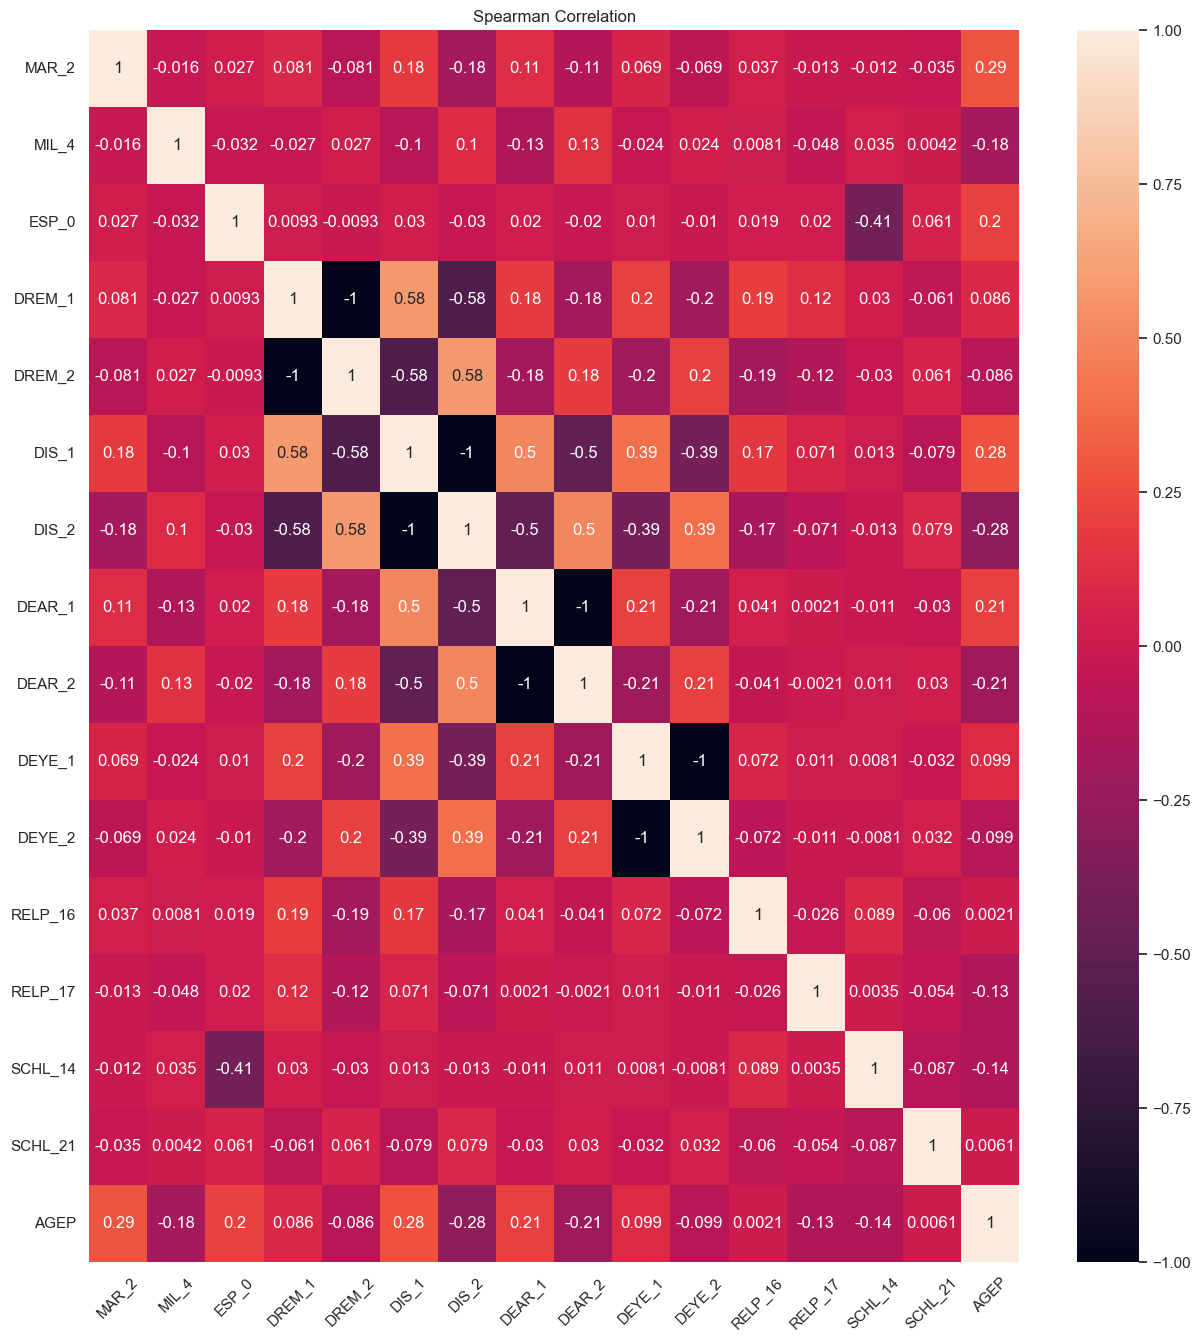

In [37]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features)

## Data preparation

In [38]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
        ('num', StandardScaler(), data_loader.numerical_columns),
    ],
    verbose_feature_names_out=False
)

In [39]:
base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

## Tune RandomForest

In [40]:
models_params_for_tuning = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
}

In [41]:
# tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, DATASET_NAME, n_folds=3)
# tuned_params_df

In [42]:
# now = datetime.now(timezone.utc)
# date_time_str = now.strftime("%Y%m%d__%H%M%S")
# tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
# tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

## Analyze Feature Importance With Scikit-Learn

In [43]:
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'RandomForestClassifier': RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=4,
                       random_state=42)}


In [44]:
rf = models_config['RandomForestClassifier']
rf = rf.fit(base_flow_dataset.X_train_val, base_flow_dataset.y_train_val)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

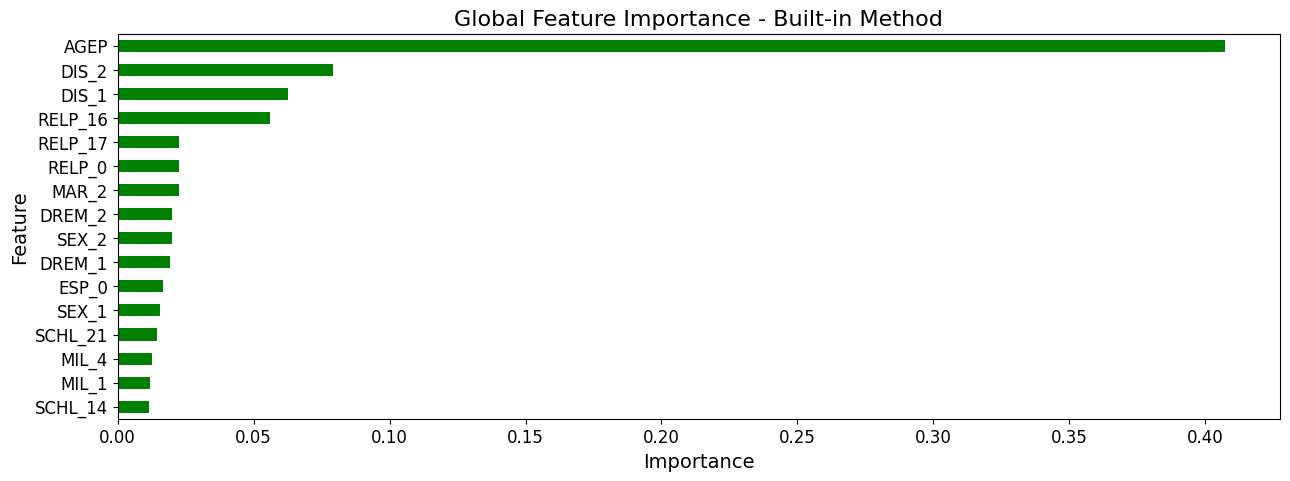

In [45]:
global_importances = pd.Series(rf.feature_importances_, index=base_flow_dataset.X_train_val.columns)
global_importances = global_importances[global_importances > 0.01]
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Global Feature Importance - Built-in Method", fontsize=16)